In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import re

In [2]:
#Gathering Data Portion
#create full dataframe with all stats
def createWRDF(years_min, years_max):
    dfwr_list = gatherData(years_min, years_max)
    dfwr_master = addNextYrFpts(dfwr_list[0], dfwr_list[1])
    for i in range(1, len(dfwr_list) - 1):
        dfwr_master = pd.concat([dfwr_master, addNextYrFpts(dfwr_list[i], dfwr_list[i + 1])])
    dfwr_master.dropna(inplace=True)
    return dfwr_master

#Create list of dataframes for each year, oldest to newest
def gatherData(years_min, years_max):
    dfwr = pd.DataFrame()
    dfwr_list = []
    for i in range(years_min, years_max + 1):
        excel_path = r"WR" + str(i) + ".xlsx"
        sheet_name = "WR" + str(i)
        dfA = pd.read_excel(excel_path, sheet_name + 'A')
        dfB = pd.read_excel(excel_path, sheet_name + 'B')
        dfwr = combine(dfA, dfB)
        dfwr = removeCans(dfwr)
        dfwr_list.append(dfwr)
    return dfwr_list

#add advanced stats from fantasy pros
def cleanFP(dfwr):
    dfwr['Player'] = dfwr['Player'].str.split("(").str[0].str.strip()
    dfwr = dfwr.drop(columns=['AIR', 'AIR/R', 'G', 'REC', 'YDS'])
    return dfwr
#add basic stats from pro football reference
def cleanPFR(dfwr):
    dfwr['Player'] = dfwr['Player'].str.replace(re.escape('*'), '', regex=True)
    dfwr['Player'] = dfwr['Player'].str.replace(re.escape('+'), '', regex=True).str.strip()
    dfwr['Fpts/G'] = dfwr.apply(lambda row: (row.Rec + row.Yds / 10 + row.TD * 6 + row.Fmb * - 2) / row.G, axis=1)
    dfwr = dfwr.drop(columns=['Tm', 'Pos', 'Y/R', 'Tgt', 'Lng', 'Rk'])
    return dfwr
#combine advanced and basic stats into one dataframe
def combine(dfwrA, dfwrB):
    dfwrA = cleanFP(dfwrA)
    dfwrB = cleanPFR(dfwrB)
    dfwr = pd.merge(dfwrA, dfwrB, left_on='Player', right_on='Player', how='inner')
    return dfwr
#add fpts/g for next season
def addNextYrFpts(dfwrcurr, dfwrnext):
    dfwrcurr = pd.merge(dfwrcurr, dfwrnext[['Player', 'Fpts/G']], left_on='Player', right_on='Player', how='inner', suffixes=('', '_nextYr'))
    return dfwrcurr
#Remove players with less than 8 games played or less than 5 fpts/g (trash cans)
def removeCans(dfwr):
    dfwr = dfwr[dfwr['G'] > 8]
    return dfwr

#Download from fp and pfr, combine to one file with two sheets, save as xlsx, WR and season number
dfwrMaster = createWRDF(13, 23)
dfwrMaster


,Rank,Player,Y/R,YBC,YBC/R,YAC,YAC/R,YACON,YACON/R,BRKTKL,...,Yds,TD,1D,Succ%,Y/Tgt,R/G,Y/G,Fmb,Fpts/G,Fpts/G_nextYr
0,2,Demaryius Thomas,15.5,733,8.0,697,7.6,0,0.0,0,...,1430,14,66,58.5,10.1,5.8,89.4,1.0,19.812500,21.181250
1,3,Calvin Johnson,17.8,1034,12.3,458,5.5,0,0.0,0,...,1492,12,69,51.9,9.6,6.0,106.6,1.0,21.657143,17.438462
2,4,A.J. Green,14.6,1033,10.5,393,4.0,0,0.0,0,...,1426,11,65,47.2,8.0,6.1,89.1,1.0,19.037500,15.623077
3,5,Brandon Marshall,13.0,1012,10.1,283,2.8,0,0.0,0,...,1295,12,70,53.0,7.9,6.3,80.9,0.0,18.843750,13.776923
4,6,Dez Bryant,13.3,709,7.6,524,5.6,0,0.0,0,...,1233,13,68,52.2,7.8,5.8,77.1,3.0,18.018750,19.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,133,Zach Pascal,10.0,64,4.3,86,5.7,8,0.5,1,...,150,1,9,63.2,7.9,0.9,8.8,0.0,2.117647,0.421429
96,136,Jalen Reagor,13.0,76,9.5,28,3.5,8,1.0,0,...,104,1,5,53.8,8.0,0.5,6.1,4.0,0.964706,1.890909
97,144,Cedrick Wilson Jr.,11.3,91,7.6,45,3.8,11,0.9,0,...,136,0,8,61.1,7.6,0.8,9.1,0.0,1.706667,4.640000
98,146,Samori Toure,16.4,71,14.2,11,2.2,5,1.0,0,...,82,1,2,30.0,8.2,0.5,7.5,1.0,1.563636,1.254545


<Axes: >

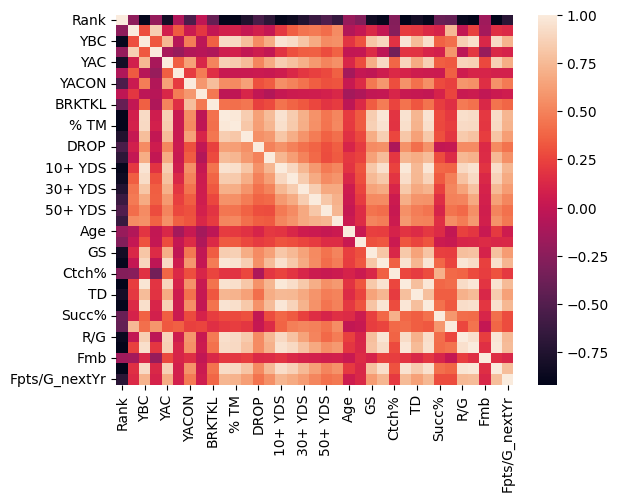

In [3]:
#Data Analysis Portion. Will add to this
corr=dfwrMaster.corr(numeric_only=True)
sns.heatmap(corr)

0.5322881284190026


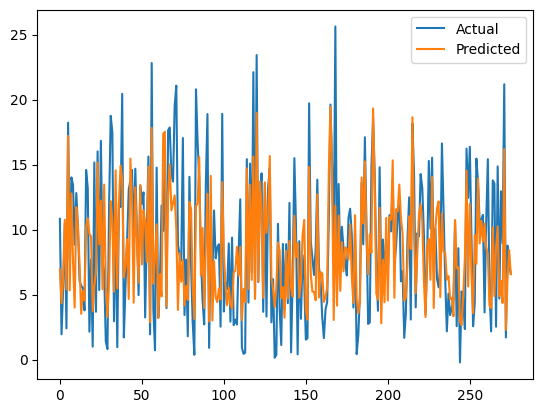

In [4]:
#Machine Learning Portion
X = dfwrMaster[['Rank', 'Y/R', 'YBC', 'YBC/R', 'YAC', 'YAC/R', 'YACON',
       'YACON/R', 'BRKTKL', 'TGT', '% TM', 'CATCHABLE', 'DROP', 'RZ TGT',
       '10+ YDS', '20+ YDS', '30+ YDS', '40+ YDS', '50+ YDS', 'LNG', 'Age',
       'G', 'GS', 'Rec', 'Ctch%', 'Yds', 'TD', '1D', 'Succ%', 'Y/Tgt', 'R/G',
       'Y/G', 'Fmb', 'Fpts/G']]
y = dfwrMaster['Fpts/G_nextYr']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, shuffle=True, test_size=0.3)

xgb_model = XGBRegressor(max_depth=6, n_estimators=500, learning_rate=0.005)
xgb_model.fit(X_train, y_train)
y_pred_test = xgb_model.predict(X_test)
xgb_pred_test = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
xgb_pred_test = xgb_pred_test.reset_index()
xgb_pred_test = xgb_pred_test.drop(['index'], axis=1)
plt.plot(xgb_pred_test)
plt.legend(['Actual', 'Predicted'])

score = r2_score(y_test, y_pred_test)
print(score)